Reading in and transforming data...
Training time: 0:00:00.059675
Train accuracy: 0.808
Time to compute train accuracy: 0:00:02.402697 Train size: 5000
Test accuracy: 0.7934
Time to compute test accuracy: 0:00:02.319773 Test size: 5000


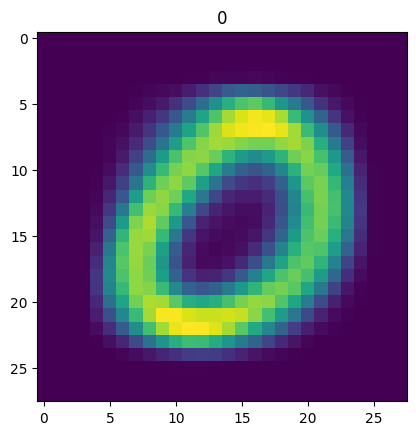

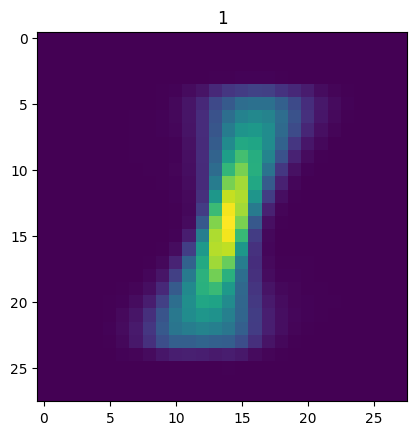

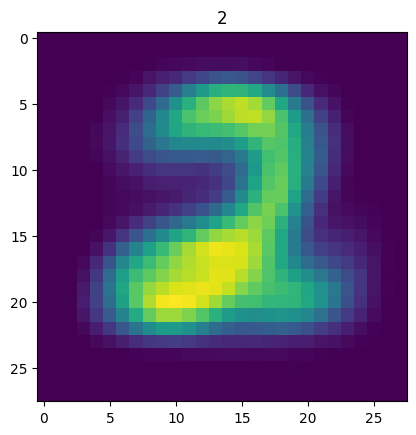

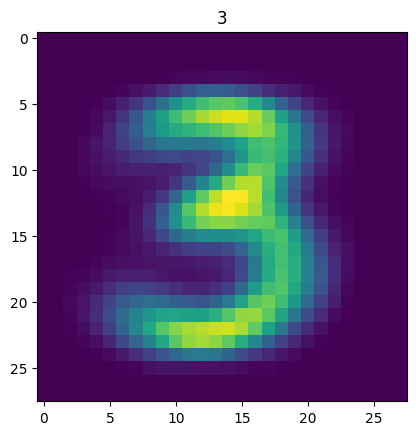

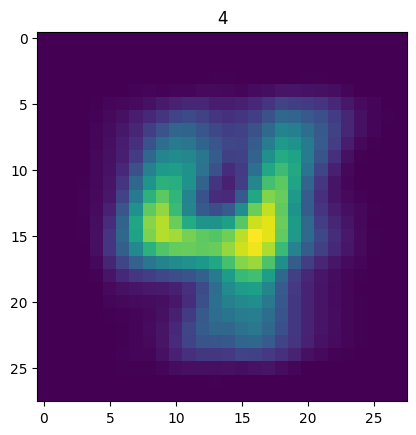

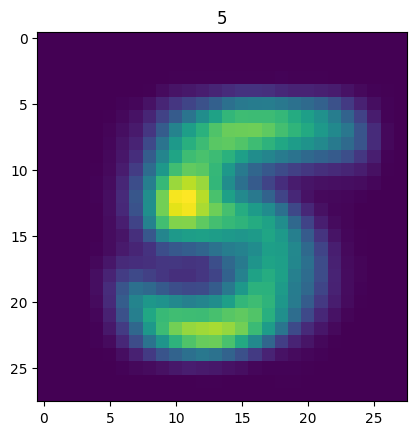

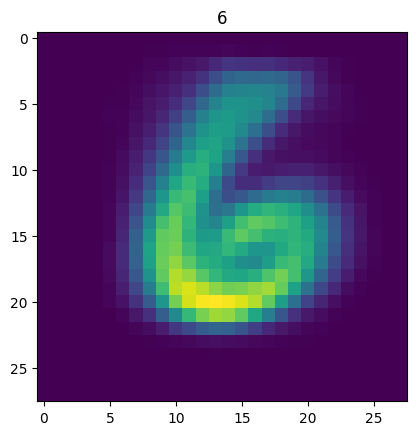

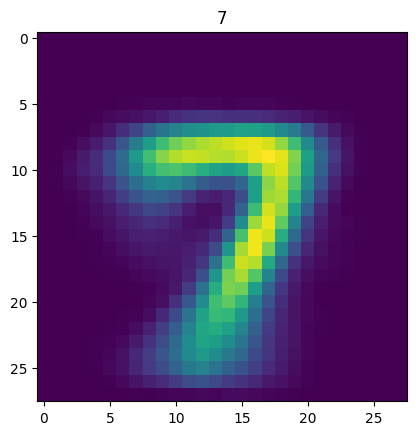

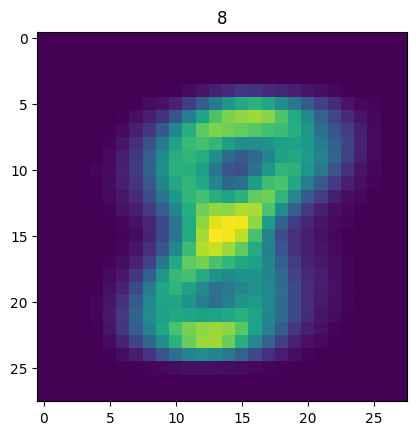

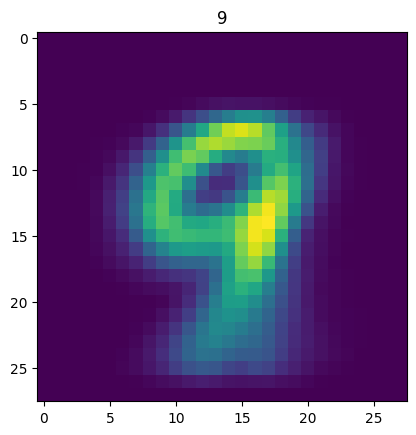

In [1]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn

def get_data(limit=None):
    print("Reading in and transforming data...")
    df = pd.read_csv('mnist_train_small.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

def get_xor():
    X = np.zeros((200, 2))
    X[:50] = np.random.random((50, 2)) / 2 + 0.5 
    X[50:100] = np.random.random((50, 2)) / 2 
    X[100:150] = np.random.random((50, 2)) / 2 + np.array([[0, 0.5]]) 
    X[150:] = np.random.random((50, 2)) / 2 + np.array([[0.5, 0]])
    Y = np.array([0]*100 + [1]*100)
    return X, Y

def get_donut():
    N = 200
    R_inner = 5
    R_outer = 10

    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))
    return X, Y

class NaiveBayes(object):
    def fit(self, X, Y, smoothing=1e-2):
        self.gaussians = dict()
        self.priors = dict()
        labels = set(Y)
        for c in labels:
            current_x = X[Y == c]
            self.gaussians[c] = {
                'mean': current_x.mean(axis=0),
                'var': current_x.var(axis=0) + smoothing,
            }
            self.priors[c] = float(len(Y[Y == c])) / len(Y)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

    def predict(self, X):
        N, D = X.shape
        K = len(self.gaussians)
        P = np.zeros((N, K))
        for c, g in iteritems(self.gaussians):
            mean, var = g['mean'], g['var']
            P[:,c] = mvn.logpdf(X, mean=mean, cov=var) + np.log(self.priors[c])
        return np.argmax(P, axis=1)


if __name__ == '__main__':
    X, Y = get_data(10000)
    Ntrain = len(Y) // 2
    Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
    Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

    model = NaiveBayes()
    t0 = datetime.now()
    model.fit(Xtrain, Ytrain)
    print("Training time:", (datetime.now() - t0))

    t0 = datetime.now()
    print("Train accuracy:", model.score(Xtrain, Ytrain))
    print("Time to compute train accuracy:", (datetime.now() - t0), "Train size:", len(Ytrain))

    t0 = datetime.now()
    print("Test accuracy:", model.score(Xtest, Ytest))
    print("Time to compute test accuracy:", (datetime.now() - t0), "Test size:", len(Ytest))

    for c, g in iteritems(model.gaussians):
        plt.imshow(g['mean'].reshape(28, 28))
        plt.title(c)
        plt.show()